# Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization


Introduksjon

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Required to import cv2 !!!
# %pip install opencv-python
import cv2

import os
import time

# Oppgave 1

## a)

Non-negative Matrix Factorization (NMF) is a technic used to represent a matrix A, but with a lower amount of data. The NMF-representation consists of two non-negative matrices W and H, where the dot product between W and H gives an approximation to the original matrix. Combined, W and H has fewer components than A, and consequently holds lower amounts of data. If A is a m x n matrix, W and H has dimensions, respectively, m x d and d x n. With a larger d, the NMF gives a better approximation to the original data. Normally one chooses a value of d that is much smaller than both n and m. However, it is important to choose a value of d that gives a good representation of A, but do not require considerable computational power. This is something we will look more into. 

<b>Induction</b>
1. 
    $W_0$ and $H_0$ are initialzed as positive, and A is assumed to be non-negative. \
    $\Rightarrow$ $W_0$ and $H_0$ are non-negative.
2. 
    Assume $W_k$ and $H_k$ are non-negative.
3. 
    Updates are given by:
    \begin{aligned}
        (H_{k+1})_{ij} \leftarrow & (H_k)_{ij} \cdot \frac{(W^T_k A)_{ij}}{(W^T_k W_k H_K)_{ij}} \\
        (W_{k+1})_{ij} \leftarrow & (W_k)_{ij} \cdot \frac{(A H^T_{k+1})_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}}
    \end{aligned}
    Since the matrix product of two non-negative matricies is also non-negative, every matrix product in the updates are non-negative, assuming that every factor is non-negative. \
    For $(H_{k+1})_{ij}$ every factor in every matrix product is assumed to be non-negative. Meaning the final product is something non-negative and non-negative. Meaning that $(H_{k+1})_{ij}$ must be non-negative. \
    The same logic works for $(W_{k+1})_{ij}$, since we now know that $(H_{k+1})_{ij}$ is also non-negative.

Therefore all iterates $W_{k}$ and $H_{k}$ are non-negative, by induction $\Box$.

## b)

Let $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ be a matrix of ones.
\begin{aligned}
    & H_{k+1} \leftarrow H_k \odot (W^T_k A) \oslash (W^T_k W_k H_k) \\
    \Rightarrow & H_{k+1} \leftarrow H_k \odot J_{m,n} \\
    \Rightarrow &\underline{H_{k+1} \leftarrow H_k} \\
\end{aligned}
Therefore if $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ is a matrix of ones, then $H_{k+1}=H_K$ and $H_k$ is a fixed point $\Box$.


Let $W_k H_k = A$.
\begin{aligned}
    (W_k^T A) \oslash (W_k^T W_k H_k) = (W_k^T A) \oslash (W_k^T A) = J_{m,n} \\
\end{aligned}
Therefore if $W_k H_k = A$, $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ is a matrix of ones.

## c)

Let $W_0=0_{m,d}$ and $H_0=0_{d,n}$.
\begin{aligned}
    & H_{1} \leftarrow H_0 \odot (W^T_0 A) \oslash (W^T_0 W_0 H_0) \\
    \Rightarrow & H_{1} \leftarrow 0_{d,n} \odot (0_{d,m} A) \oslash (0_{d,m} 0_{m,d} 0_{d,n}) \\
    \Rightarrow & H_{1} \leftarrow 0_{d,n} \odot (0_{d,n}) \oslash (0_{d,n}) \\
\end{aligned}
This leads to being needed to calculate $0/0$, which is undefined. This is clearly problematic, and should be avoided.

# Oppgave 2

## Introduksjon

Now that NMF is both defined and implemented, it is interersting to investigate it's properties. Therefore there is a need of a large dataset to apply NMF to. The dataset which will be used is 10 000 Cryptopunks NFTs. A Cryptopunk is a digital 24 x 24 RGBA image. Every Cryptopunk is algorithmically generated, meaning certain features such as cigarettes and hairstyles are shared between images. This means that the images should be more or less able to be decomposed into image components, so that every image can be described as a sum of image components. To verify this claim we are going to make us of the NMF-algorithm to approximate such a components and decompisitions.

Now we need to represent the data in such a way that it is possible to apply the NMF-algorithm. Firstly we randomly select N Cryptopunks from the pool of 10 000. This gives 500 24 x 24 RGBA images. A natural way to store the images is to store them in a 24 x 24 x 4 x N array, i.e. 24 rows x 24 columns x 4 color channels x N images. Below is a function which loads 500 randomly picked images from the dataset a stores them in an array as described. One thing to note is that the RGBA-values are divided by 255.0. This is to create a array of floats, with values from 0 to 1.

In [5]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
                
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)

(24, 24, 4, 500)


With the images now being loaded into the kernel it is now possible to plot and view some of the images picked. Below is a function which plots the first $nplot^2$ images in the input array in a square grid. After the implementation a 8 x 8 grid of the images loaded in the kernel are plotted.

In [6]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

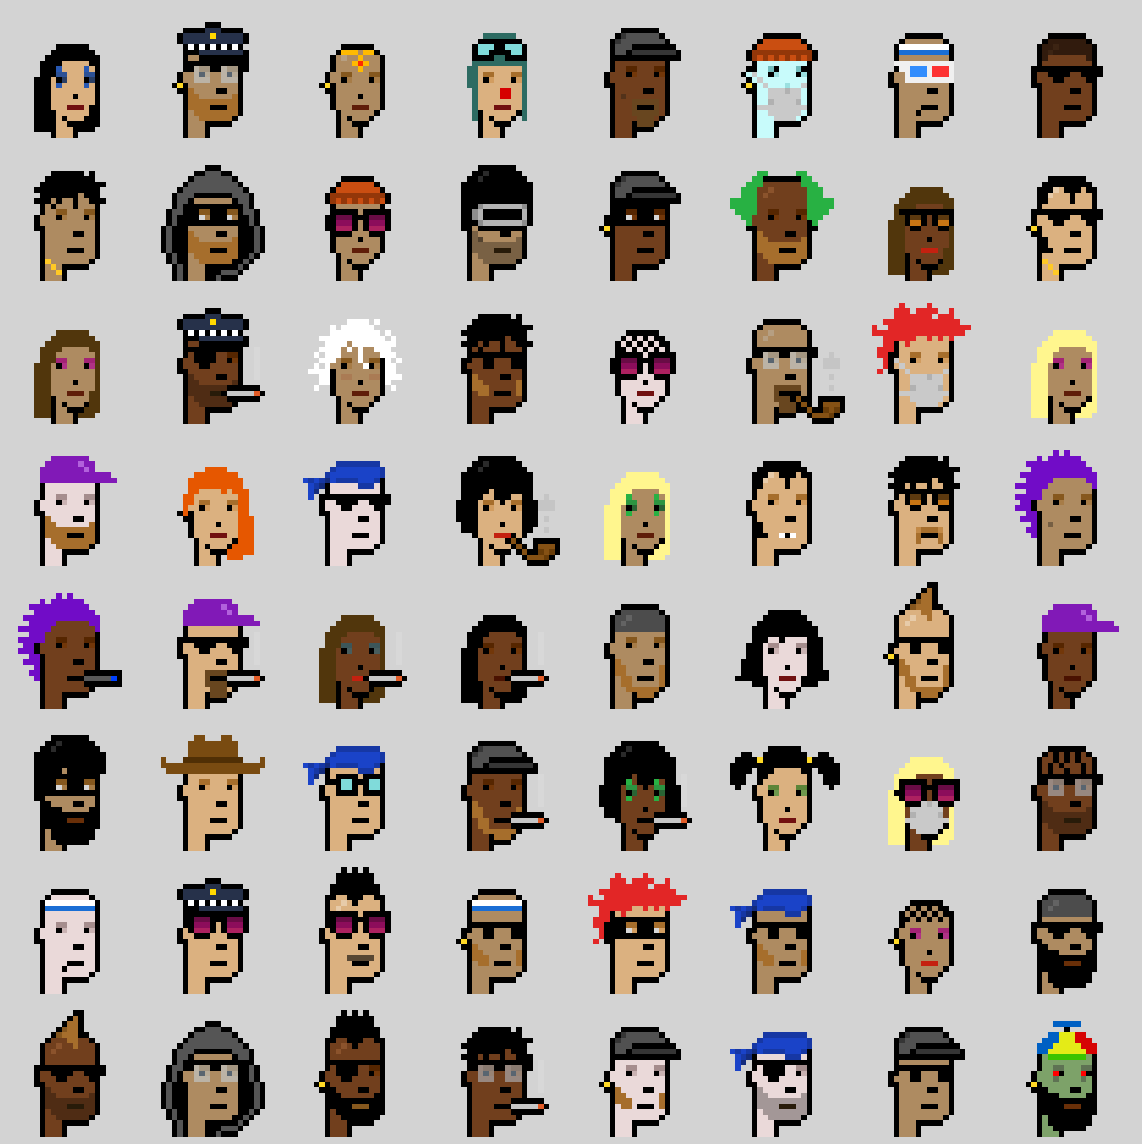

In [7]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

In the above images some common features are clearly possible to be seen, which is a good indication that the NMF-algorithm should be able to reduce the amount of data to store the images. We will now start applying the NMF-algorithm to verify our previous claims, and to see if the algorithm is able to decompose the images into image components.